# Lab 4: Data augmentation, Dropout, and Per-class Accuracy

## Contents

1. [Data Augmentation](#Data-Augmentation)
    1. [PyTorch Transformation Pipelines](#PyTorch-transformation-pipelines)
    2. [Playing with datasets](#Playing-with-datasets)
    3. [Online vs. Offline Augmentation](#Online-vs.-Offline-Augmentation)
    4. [Training with Horizontal Flips](#Training-with-Horizontal-Flips)
    5. [Training with Variable Brightness](#Training-with-Variable-Brightness)
    6. [Training with Another Augmentation Technique](#Training-with-Another-Augmentation-Technique)
2. [Dropout](#Dropout)
3. [Per-class Accuracy](#Per-class-Accuracy)
4. Optional Extension: [Model Checkpointing](#Optional-Extension:-Model-Checkpointing)

Last lab session we looked at ways of reducing overfitting in our network. The methods we used were either tweaks to the optimisation process (tuning learning rate/batch size, using momentum) or adaptations to the network architecture (batch normalisation).  This week we will look at how we can improve our network's performance through the use of data augmentation techniques. That is, constructing more data from what we already have through the application of transformations (e.g. horizontal flipping, rotation, etc) that preserve the examples' labels. These transformations will introduce more variety into our training data to improve generalisation and reduce overfitting.

We'll introduce one final network adaptation, *dropout*, to reduce overfitting.

Finally we'll look at another way of measuring performance, *per-class accuracy*, which you'll be using in your coursework.

---
## Data Augmentation

Data augmentation refers to the process of applying transforms to existing data that preserves the labels of dataset elements. Examples of this include horizontally flipping, cropping, and adding small amounts of noise.

### Online vs. Offline Augmentation

So how do we augment our training data? Your first thought might be to apply the transforms and save the new data, additionally training on this new data.
This is called **offline augmentation**.
An alternative approach is to load an unalterated example from the dataset and apply a transform (like flipping it, or adjusting its brightness) with some probability, this is called **online augmentation**.
One of the major benefits of online augmentation is the greater diversity we can achieve in our data: each time the example is loaded it might be transformed in a different way. 
This is especially true when we apply multiple stochastic transforms one after the other.
Offline augmentation is typically used when transform operations are very expensive and computing them online during training would massively slow down the training process due to waiting on the execution of the transformations.

We'll only be using online augmentation in this lab as the transforms are relatively cheap to apply on the fly. Very few people working with DNNs operating on images use offline augmentation.

### PyTorch transformation pipelines

In PyTorch, datasets typically have a constructor parameter, `transform`, which you can use to inject an arbitrary transform that is applied to each data sample. Up to this point, our code uses this to convert images from [`PIL.Image.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html#the-image-class) objects to `torch.Tensor` objects by using the [`ToTensor`](https://pytorch.org/docs/1.2.0/torchvision/transforms.html#torchvision.transforms.ToTensor) transform as can be seen in the excerpt below:

```python
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.CIFAR10(
    args.dataset_root, train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    args.dataset_root, train=False, download=False, transform=transform
)
```

Above, we only used a single transform, but it is very common to want to chain multiple transforms together into a pipeline.
Torchvision provides a class, [`Compose`](https://pytorch.org/docs/1.2.0/torchvision/transforms.html#torchvision.transforms.Compose), to facilitate this. 
It is very simple, storing a list of transforms and applying one in turn when it is called on an input.

For example, we could combine random horizontal flipping followed by converting the PIL Images to torch tensors like so:

```python
transform = Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
])
```


### Playing with datasets

Let's get some hands on experience and play around the [`CIFAR10`](https://pytorch.org/docs/1.2.0/torchvision/datasets.html#torchvision.datasets.CIFAR10) dataset and the `torchvision` transforms.

**Task:** Open up a [colaboratory notebook](https://colab.research.google.com/) and run the following code

```python
import torch
import torchvision

dataset = torchvision.datasets.CIFAR10('data', download=True, train=True)
img, label = dataset[1]
print(type(img))
print(label)
img
```

Note that we **don't** set the `transform` argument of the [`CIFAR10`](https://pytorch.org/docs/1.2.0/torchvision/datasets.html#torchvision.datasets.CIFAR10) constructor; it will return the data without any transforms applied to it.
This will enable us to easily play around with new transforms without having to reconstruct the dataset class with a different transform repeatedly.
The [`CIFAR10`](https://pytorch.org/docs/1.2.0/torchvision/datasets.html#torchvision.datasets.CIFAR10) dataset reads images as [`PIL.Image.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html#the-image-class) objects by default.

Have a look at what transforms `torchvision` provides for working with [`PIL.Image.Image`](https://pillow.readthedocs.io/en/stable/reference/Image.html#the-image-class) objects: https://pytorch.org/docs/1.2.0/torchvision/transforms.html#transforms-on-pil-image

Let's test out the [`RandomHorizontalFlip`](https://pytorch.org/docs/1.2.0/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip) transform.

**Task:**  In a new cell construct a [`RandomHorizontalFlip`](https://pytorch.org/docs/1.2.0/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip) transform 
```python
from torchvision.transforms import RandomHorizontalFlip
transform = RandomHorizontalFlip()
transform(img)
```

Repeatedly rerun the cell and see how the image changes each time you run the cell. The transform is stochastic.

100.0%


Extracting data/cifar-10-python.tar.gz to data
<class 'PIL.Image.Image'>
9


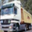

In [2]:
import torch
import torchvision

dataset = torchvision.datasets.CIFAR10('data', download=True, train=True)
img, label = dataset[1]
print(type(img))
print(label)
img

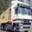

In [3]:
from torchvision.transforms import RandomHorizontalFlip
transform = RandomHorizontalFlip()
transform(img)

**Question** what are some of the commonly used data augmentation techniques? 

--- 
### Training with Horizontal Flips

Now that you've played around with horizontal flipping in Colaboratory, it's time to use it to augment our training data.

**Task:** 
- Make a copy of last week's code
- Add a [new option to the argument parser](https://docs.python.org/3/library/argparse.html#argparse.ArgumentParser.add_argument) in `train_cifar.py` called `--data-aug-hflip` with `action='store_true'`:

In [ ]:
parser.add_argument("--data-aug-hflip", action="store_true")

- If this argument (which is stored in the variable `args.data_aug_hflip`) is `True`, then apply the transform  before `ToTensor` using [`Compose`](https://pytorch.org/docs/1.2.0/torchvision/transforms.html#torchvision.transforms.Compose) to combine the transforms. Make sure to apply data augmentation transforms during training **only**.
- Update `tb_log_dir_prefix` in `get_summary_writer_log_dir` to read 
  ```python
    tb_log_dir_prefix = (
        f"CNN_bn_"
        f"bs={args.batch_size}_"
        f"lr={args.learning_rate}_"
        f"momentum=0.9_" +
        ("hflip_" if args.data_aug_hflip else "") +
        f"run_"
    )
  ```
- Train the network with LR=1e-1, BS=128, momentum=0.9 and with horizontal flipping. Compare the final performance against your network trained without horizontal flipping. Did the data augmentation reduce overfitting of the network at all?

**Question** when can horizontal flipping add no value?

---
### Training with Another Augmentation Technique

**Task**:
Pick one additional transformation from [`torchvision.transforms`](https://pytorch.org/docs/1.2.0/torchvision/transforms.html#transforms-on-pil-image) suitable for introducing more variation in training. 
Be careful to pick a transform that introduces diversity that is likely to be present in your test set.
A bad choice would be to additionally train on grayscale images since the test data only contains color images.

- *(Optionally)* experiment with the transform in your colaboratory notebook.
- Add an option flag to the parser for this transform.
- Update `tb_log_dir_prefix` to include some string that indicates what additional transform has been applied.
- Train your network with only this new augmentation and compare against the performance of your network without any augmentation.
- Note any impact on the severity of overfitting and the final test set performance.

---
### Training with Variable Brightness 


Another way of introducing more variation into the training data is by randomly adjusting the brightness of images, making them either darker or brighter.
Torchvision provides a transform called [`ColorJitter`](https://pytorch.org/docs/1.2.0/torchvision/transforms.html#torchvision.transforms.ColorJitter) suitable for this purpose.
`ColorJitter` takes an argument `brightness` that defines how much to vary the brightness by; it should be set to a value between 0 and 1. 
The image's brightness will be adjusted by multiplying it by a factor sampled from $U[1-b, 1+b]$ where $b$ is the brightness factor passed in the constructor. Afterwards, the new pixel values are clipped to lie in the range $[0, 255]$.


**Task**: 
- Add a [new option to the argument parser](https://docs.python.org/3/library/argparse.html#argparse.ArgumentParser.add_argument) in `train_cifar.py` called `--data-aug-brightness` with the default `0` and type `float`.
- Construct a [`ColorJitter`](https://pytorch.org/docs/1.2.0/torchvision/transforms.html#torchvision.transforms.ColorJitter) transform and add it to the training transform. 
- Update `tb_log_dir_prefix` in `get_summary_writer_log_dir` to read:
  ```python
    tb_log_dir_prefix = (
        f"CNN_bn_"
        f"bs={args.batch_size}_"
        f"lr={args.learning_rate}_"
        f"momentum=0.9_"
        f"brightness={args.data_aug_brightness}_" +
        ("hflip_" if args.data_aug_hflip else "") +
        f"run_"
    )
    ```
- Retrain the network varying the amount of brightness jittering, try the following values: 0.05, 0.1, 0.3. Use BS=128, LR=1e-1, momentum=0.9, and don't use horizontal flipping. Does this technique help reduce overfitting or improve generalisation?
- Retrain the network with brightness jittering of 0.1, but this time *also* include horizontal flipping as an augmentation technique.

**Question** can excess color jittering hurt performance? if so, why?

---
## Per-class accuracy

So far we've used a single metric, *accuracy*, to measure the performance of your model on either the training or test set. Whilst this is useful to get an overall picture of performance, it is rather uninformative when it comes to understanding where the model does well or falls down. We can gain a more nuanced understanding of the model's performance by computing the accuracy per-class (this is a slight misnomer as technically this is per-class recall).

Previously, we've computed accuracy by

$$ \mathrm{Acc} = \frac{\sum_i \operatorname{I}[\hat{y}_i = y_i]}{N}$$

where 
- $\hat{y}_i$ is the model's classification of example $i$.
- $y_i$ is the label of example $i$.
- $\operatorname{I}[\cdot]$ is the indicator function that returns 1 if its argument is true, and 0 otherwise.
- $N$ is the total number of examples.

We can compute this on a per-class basis by looking at the set of examples labelled with class $C$ and counting how many were correctly classified divided by the total number examples of $C$:

$$ \mathrm{Acc}_C = \frac{\sum_i \operatorname{I}[\hat{y}_i = y_i = C]}{\sum_i \operatorname{I}[y_i = C]} $$

**Task:** Implement a function to compute per-class accuracy and print out the per-class accuracy after every validation step. The network's logit indices correspond to the classes in alphabetic order, i.e. logit 0 → airplane, logit 1 → automobile, ..., logit 9 → truck. The classes in CIFAR10 can be found [here](https://www.cs.toronto.edu/~kriz/cifar.html).

There are many different ways to implement this. If you need a hint to get you started, you can use `==` to obtain a boolean mask indicating whether corresponding elements have the same class. This could be used to compute how many labels correspond to the class of interest in addition to how many labels are correct.

**Question** When can computing the accuracy lead to a biased estimation of the model's performance?

---
## Dropout

A popular regularisation technique is called **dropout**.
Dropout prevents overfitting by randomly removing inputs to a layer. This means that the layer can't rely on a large number of inputs always being present to recognise a specific concept and has to instead rely on fewer combinations of inputs to detect these concepts.
The [original paper](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) puts forward a good explanation:

> Deep neural networks contain multiple non-linear hidden layers and this makes them very expressive models that can learn very complicated relationships between their inputs and outputs. With limited training data, however, many of these complicated relationships will be the result of sampling noise, so they will exist in the training set but not in real test data even if it is drawn from the same distribution.  This leads to overfitting ...

Dropout stochastically removes input units, resulting in those units having no effect. Each unit is independently dropped-out with probability $p$. The effect of dropout on the network structure can be seen in the figure below:

![Dropout networks](./media/dropout.png)

Setting input units to 0 has the same effect as removing the edges between output neurons and the input units that have been dropped out.

Typically, dropout is implemented by sampling a *dropout mask* $\mathbf{m}$ from a multivariate [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) and using this to gate the inputs.
For a layer with $D$ inputs, $D$ binary samples are drawn from $\mathrm{B}(1-p)$ (a Bernoulli distribution with mean $1-p$) to form $\mathbf{m} \in \{0, 1\}^D$. The inputs $\mathbf{x} \in \mathbb{R}^D$ are then gated by the dropout mask $\mathbf{x}\odot \mathbf{m}$ (where $\odot$ represents elementwise multiplication) before being passed into the layer.
As previously stated, this only happens during training, and at test time the inputs are left untouched.

One issue we haven't noted with the above formulation is the difference in input distributions to the layer during training vs. testing.
Consider dropping out the inputs to a fully connected layer. 
Let's look at one of the neurons in the layer, each of which are connected to the $D$ inputs.
The expected input to a neuron during training will be 
$$\mathbb{E}[\mathbf{m} \odot \mathbf{x}] = \mathbb{E}[\mathbf{m}] \odot \mathbb{E}[\mathbf{x}] = (1-p) \mathbb{E}[\mathbf{x}]$$
but during testing it will instead be $\mathbb{E}[\mathbf{x}]$.
So, the expected difference between training and testing in the input to the neuron is $\frac{1}{1-p}$.
This is easily resolvable by rescaling the inputs during training, we simply weight the inputs by $\frac{1}{1-p}$ during training and leave them untouched during testing. This keeps the expected value of the inputs the same during testing or training.


See the [original paper](http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf) for more details, it is eminently readable. Be aware that they define $p$ to be the probability that a neuron is retained, rather than dropped, most frameworks these days define it like we have defined above. The scaling used to keep the expected value of the inputs the same during training and testing also differs to that above, but achieves the same end.

Dropout is typically applied on the input to FC layers, but can also be applied to the input of any hidden layer.
Typical dropout probabilities are 0.5--0.8 for FC layers, but much lower for convolutional layers such as 0.1.

**Task:** 
- Add a [new option flag](https://docs.python.org/3/library/argparse.html#argparse.ArgumentParser.add_argument) `--dropout` with a default value of 0 and type `float`. 
- Apply dropout to the input of each fully connected layer
 - Make a new constructor argument called `dropout` in the `CNN` class.
 - Pass in the dropout value stored in `args.dropout` when constructing the `CNN` class.
 - In `CNN`'s constructor, make a [`nn.Dropout`](https://pytorch.org/docs/1.2.0/nn.html#torch.nn.Dropout) object constructed with the `dropout` parameter, and assign it to `self.dropout`.
 - In the `forward` method, apply `self.droput` to the input of each fully connected layer.
- Update `tb_log_dir_prefix` in `get_summary_writer_log_dir` to read:
  ```python
    tb_log_dir_prefix = (
        f"CNN_bn_"
        f"dropout={args.dropout}_"
        ...
    )
    ```
- Train the model with BS=128, LR=1e-1, momentum=0.9 and $p = 0.5$ (the probability of dropping out an input) 


As always, here are the results when we scanned across a range of droput values:

| Dropout $p$   | Train accuracy (%)   | Test accuracy (%)   | Train-test accuracy gap (%)   |
| ------------- | -------------------- | ------------------- | ----------------------------- |
| 0.0           | 100.00               | 76.56               | 23.44                         |
| 0.1           | 99.60                | 76.31               | 23.29                         |
| 0.2           | 98.33                | 75.99               | 22.34                         |
| 0.3           | 95.42                | 78.09               | 17.33                         |
| 0.4           | 92.46                | 76.38               | 16.08                         |
| 0.5           | 84.96                | 77.90               | 7.06                          |
| 0.6           | 77.21                | 79.60               | -2.39                         |
| 0.7           | 71.17                | 70.55               | 0.62                          |
| 0.8           | 59.60                | 61.73               | -2.13                         |
| 0.9           | 17.10                | 19.53               | -2.43                         |

Notice how dropout has a profound effect on reducing the training accuracy, it acts as an excellent regulariser.

**Question** what are the pros and cons of using dropout compared to other regularization methods such as L2 norm?


---
## Optional Extension: Model Checkpointing

Training networks can take a long time, sometimes even weeks. It is not feasible to continually retrain networks when you want to evaluate them. To avoid this we perform *checkpointing* which is the process of saving model parameters every so often so that if our script crashes we can resume training and more importantly, separate the evaluation of the trained network from the training process itself. 

In PyTorch, the parameters of a model can be obtained by calling [`model.state_dict()`](https://pytorch.org/docs/1.2.0/nn.html#torch.nn.Module.state_dict), this returns a dictionary mapping between parameter names and tensors containing those parameters. You can save this dictionary to a file using [`torch.save`](https://pytorch.org/docs/1.2.0/torch.html#torch.save), read it from disk using [`torch.load`](https://pytorch.org/docs/1.2.0/torch.html#torch.load), and finally load it back into the network using [`model.load_state_dict(state_dict)`](https://pytorch.org/docs/1.2.0/nn.html#torch.nn.Module.load_state_dict)

A sketch of the general set up of the checkpointing process is given below (this is *not* complete code, but shows you the outline of the general process):

```python
parser.add_argument("--checkpoint-path", type=Path)
parser.add_argument("--checkpoint-frequency", type=int, default=1, help="Save a checkpoint every N epochs")
parser.add_argument("--resume-checkpoint", type=Path)
parser.add_argument("--start-epoch", type=int, default=0)

if args.resume_checkpoint.exists():
    state_dict = torch.load(args.resume_checkpoint)
    print(f"Loading model from {args.resume_checkpoint}")
    model.load_state_dict(state_dict)
    

for epoch in range(epochs):
    train_for_one_epoch(model)
    # Save every args.checkpoint_frequency or if this is the last epoch
    if (epoch + 1) % args.checkpoint_frequency == 0 or (epoch + 1) == epochs:
        print(f"Saving model to {args.checkpoint_path}")
        torch.save(model.state_dict(), args.checkpoint_path)
```


**TASK**: Using the above example code, implement model checkpointing in your code.


You can save any object using `torch.save`. It is useful to persist more than just your model parameters. For example you could store your command line args so you can determine what hyperparameters were used to train that particular model. Another good idea is to save the accuracy the model achieves in validation, e.g.:

```python
torch.save({
    'args': args,
    'model': model.state_dict(),
    'accuracy': accuracy
}, args.checkpoint_path)
```

then when you load the checkpoint you will have to pull out the state dict to load into the model:

```python
checkpoint = torch.load(args.resume_checkpoint)
print(f"Resuming model {args.resume_checkpoint} that achieved {checkpoint['accuracy']}% accuracy")
model.load_state_dict(checkpoint['model'])
```

**TASK**: Write an additional script that loads your checkpoint and evaluates it on the test set. You will probably want to split up your python code into multiple files so that the CNN class resides in its own file and the training and testing scripts import this definition.

You might find the [PyTorch tutorial on checkpointing](https://pytorch.org/tutorials/beginner/saving_loading_models.html) a useful resource in implementing this extension.

**Question** what are some additional criteria you need to consider if you are saving checkpoints while training in a distributed manner?